In [1]:
# https://www.kaggle.com/artgor/santander-eda-fe-fs-and-models

In [2]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
np.__version__

'1.15.4'

In [4]:
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast

In [5]:
from catboost import CatBoostClassifier
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook

In [6]:

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv('../data/train.csv.zip')
test = pd.read_csv('../data/test.csv.zip')
train.shape, test.shape

((200000, 202), (200000, 201))

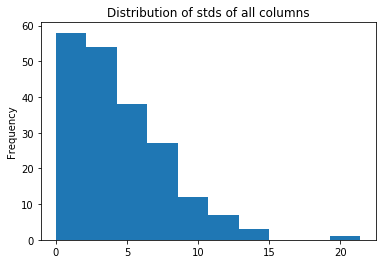

In [8]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

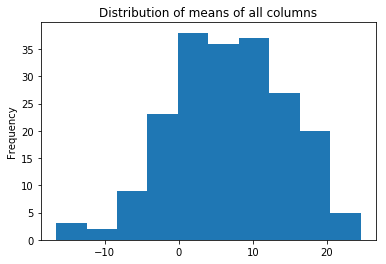

In [9]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

Distributions of first 28 columns


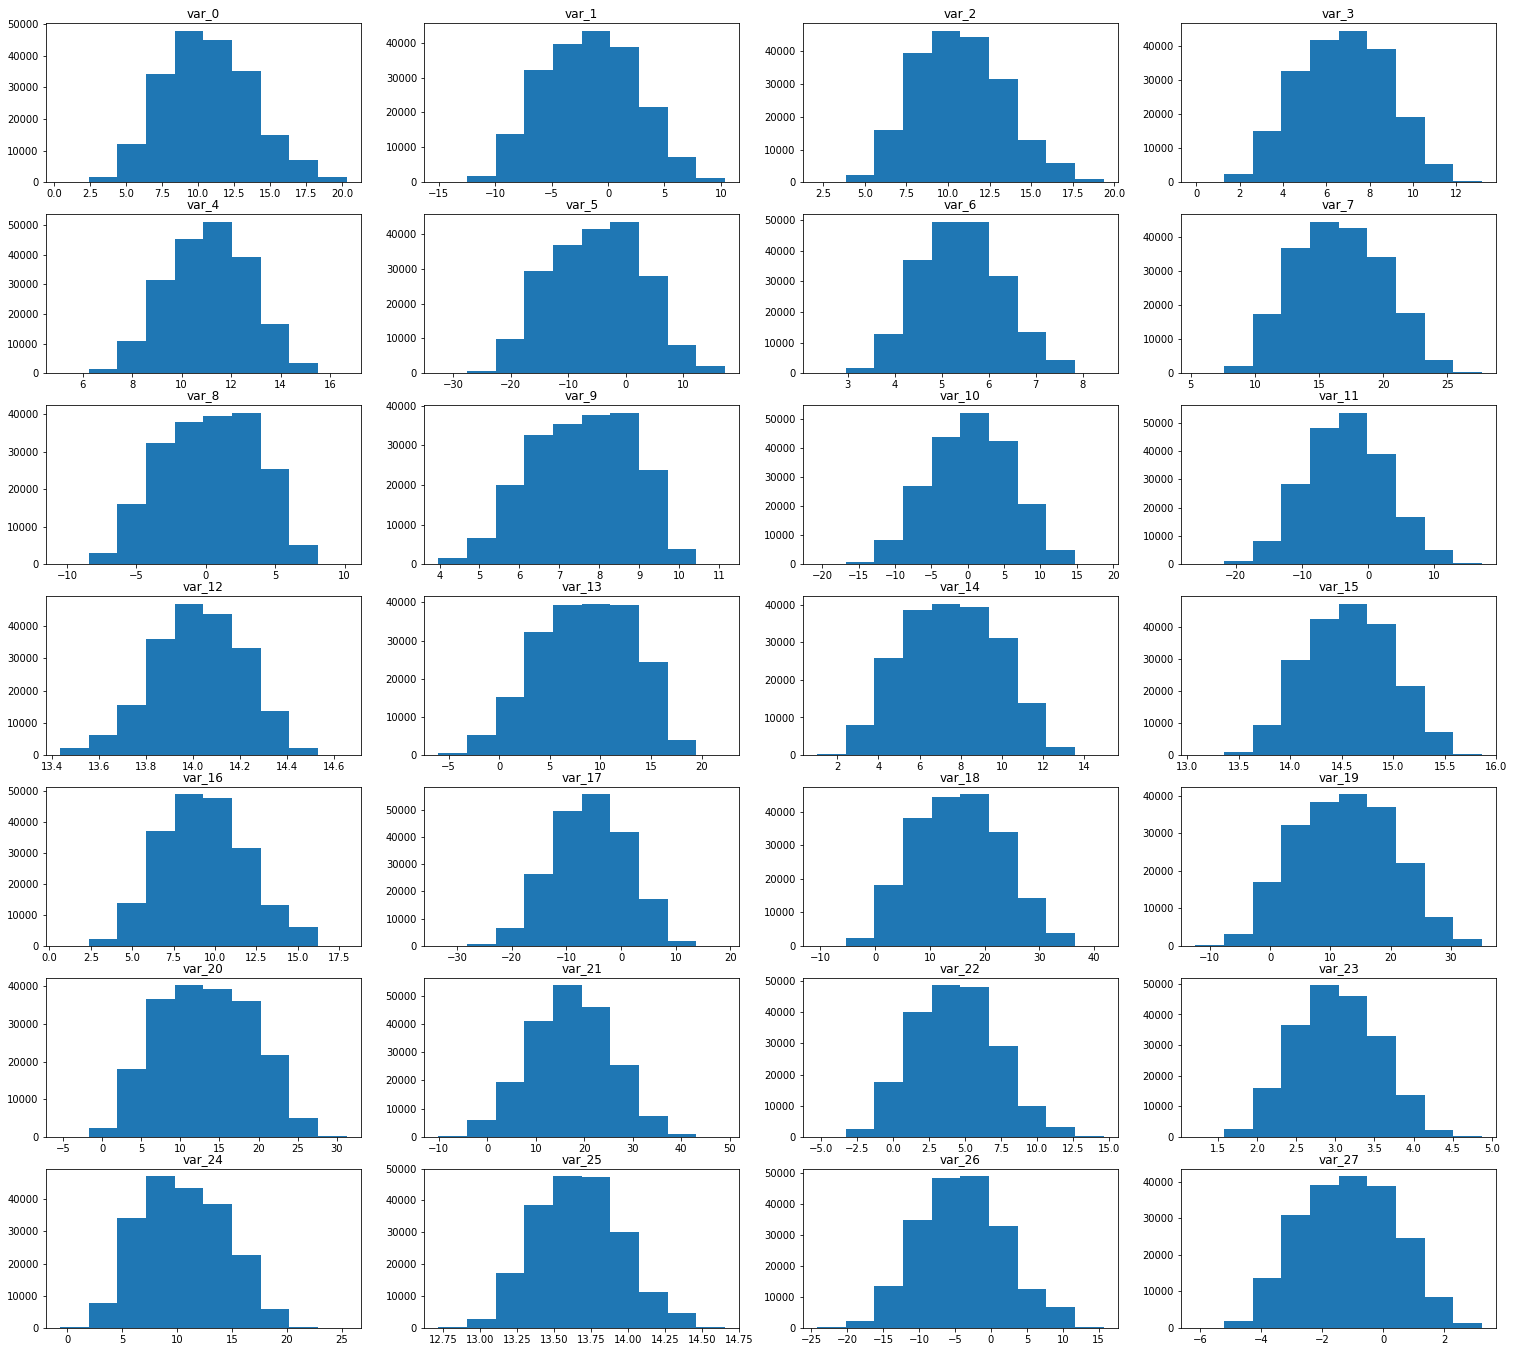

In [10]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

Distributions of first 28 columns


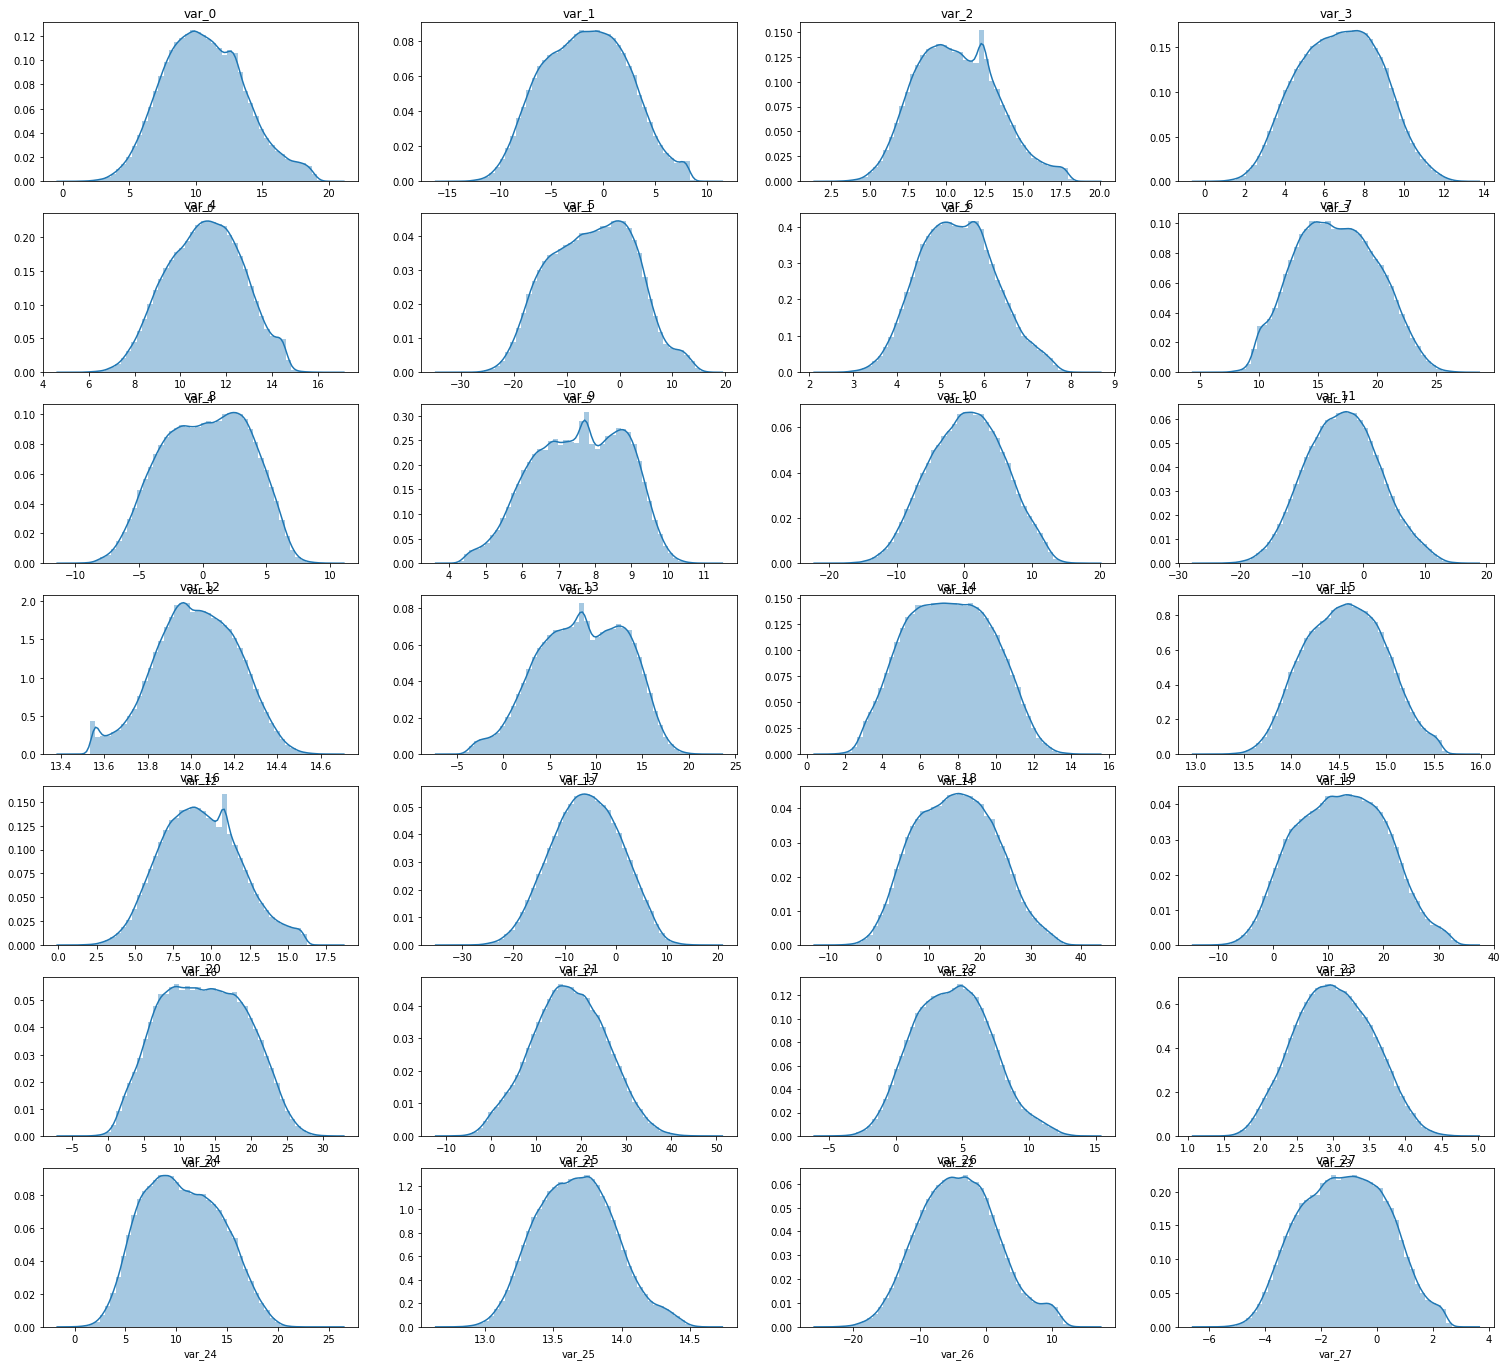

In [11]:
import seaborn as sns
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    sns.distplot(train[col])
    plt.title(col)

In [12]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

In [12]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [13]:
# sample_pos_weight = number of negative samples / number of positive samples
sample_pos_weight = 179902/ 20098

In [14]:
sample_pos_weight

8.951238929246692

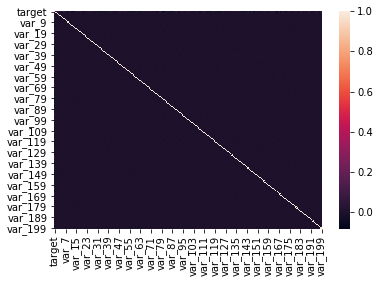

In [13]:
sns.heatmap(train.corr())

In [15]:
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop(['ID_code'], axis=1)
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

In [15]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'max_depth': int(params['max_depth']),
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        'bagging_freq': int(params['bagging_freq']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'reg_alpha': '{:.3f}'.format(params['reg_alpha']),
        'reg_lambda': '{:.3f}'.format(params['reg_lambda']),
        'subsample': '{:.3f}'.format(params['subsample']),
        
        'min_child_weight': '{:.3f}'.format(params['min_child_weight']),
    }
    
    clf = lgb.LGBMClassifier(
        num_threads=-1,
        **params
    )
    
    score = cross_val_score(clf, X, y, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1).mean()
    print("ROC-AUC {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 50, 2),
    'max_depth': hp.quniform('max_depth', 2, 20, 2),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.05),
    'bagging_freq': hp.quniform('bagging_freq', 2, 14, 2),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1.0),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    
    'min_child_weight': hp.uniform('min_child_weight', 0.0, 100.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.4s remaining:   39.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished


ROC-AUC 0.805 params {'num_leaves': 60, 'min_data_in_leaf': 12, 'max_depth': 16, 'learning_rate': '0.002', 'bagging_freq': 10, 'feature_fraction': '0.714', 'reg_alpha': '0.637', 'reg_lambda': '0.842', 'subsample': '0.100', 'min_child_weight': '6.577'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   55.8s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.0s finished


ROC-AUC 0.845 params {'num_leaves': 52, 'min_data_in_leaf': 22, 'max_depth': 18, 'learning_rate': '0.038', 'bagging_freq': 4, 'feature_fraction': '0.858', 'reg_alpha': '0.793', 'reg_lambda': '0.963', 'subsample': '0.947', 'min_child_weight': '60.851'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.7s remaining:   37.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


ROC-AUC 0.864 params {'num_leaves': 102, 'min_data_in_leaf': 20, 'max_depth': 16, 'learning_rate': '0.026', 'bagging_freq': 8, 'feature_fraction': '0.158', 'reg_alpha': '0.213', 'reg_lambda': '0.149', 'subsample': '0.706', 'min_child_weight': '49.823'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.7s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s finished


ROC-AUC 0.837 params {'num_leaves': 82, 'min_data_in_leaf': 26, 'max_depth': 8, 'learning_rate': '0.031', 'bagging_freq': 8, 'feature_fraction': '0.670', 'reg_alpha': '0.373', 'reg_lambda': '0.581', 'subsample': '0.589', 'min_child_weight': '25.225'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.7s remaining:   55.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.2s finished


ROC-AUC 0.735 params {'num_leaves': 22, 'min_data_in_leaf': 2, 'max_depth': 12, 'learning_rate': '0.005', 'bagging_freq': 12, 'feature_fraction': '0.925', 'reg_alpha': '0.387', 'reg_lambda': '0.504', 'subsample': '0.967', 'min_child_weight': '67.023'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.8s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished


ROC-AUC 0.757 params {'num_leaves': 90, 'min_data_in_leaf': 6, 'max_depth': 2, 'learning_rate': '0.003', 'bagging_freq': 6, 'feature_fraction': '0.115', 'reg_alpha': '0.814', 'reg_lambda': '0.935', 'subsample': '0.287', 'min_child_weight': '99.019'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.0s remaining:   28.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


ROC-AUC 0.831 params {'num_leaves': 14, 'min_data_in_leaf': 6, 'max_depth': 18, 'learning_rate': '0.036', 'bagging_freq': 4, 'feature_fraction': '0.607', 'reg_alpha': '0.155', 'reg_lambda': '0.455', 'subsample': '0.403', 'min_child_weight': '96.810'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.9s remaining:   53.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.3s finished


ROC-AUC 0.830 params {'num_leaves': 68, 'min_data_in_leaf': 10, 'max_depth': 12, 'learning_rate': '0.017', 'bagging_freq': 4, 'feature_fraction': '0.968', 'reg_alpha': '0.790', 'reg_lambda': '0.394', 'subsample': '0.239', 'min_child_weight': '6.980'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.4s remaining:   42.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished


ROC-AUC 0.823 params {'num_leaves': 68, 'min_data_in_leaf': 14, 'max_depth': 6, 'learning_rate': '0.032', 'bagging_freq': 12, 'feature_fraction': '0.583', 'reg_alpha': '0.209', 'reg_lambda': '0.144', 'subsample': '0.941', 'min_child_weight': '5.511'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.3s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.1s finished


ROC-AUC 0.819 params {'num_leaves': 126, 'min_data_in_leaf': 36, 'max_depth': 4, 'learning_rate': '0.041', 'bagging_freq': 12, 'feature_fraction': '0.216', 'reg_alpha': '0.737', 'reg_lambda': '0.560', 'subsample': '0.496', 'min_child_weight': '47.419'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.6s remaining:   45.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished


ROC-AUC 0.792 params {'num_leaves': 66, 'min_data_in_leaf': 4, 'max_depth': 8, 'learning_rate': '0.009', 'bagging_freq': 10, 'feature_fraction': '0.749', 'reg_alpha': '0.509', 'reg_lambda': '0.469', 'subsample': '0.440', 'min_child_weight': '8.132'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.4s remaining:   41.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished


ROC-AUC 0.823 params {'num_leaves': 58, 'min_data_in_leaf': 46, 'max_depth': 14, 'learning_rate': '0.015', 'bagging_freq': 8, 'feature_fraction': '0.369', 'reg_alpha': '0.700', 'reg_lambda': '0.967', 'subsample': '0.635', 'min_child_weight': '90.526'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.2s remaining:   52.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.7s finished


ROC-AUC 0.865 params {'num_leaves': 92, 'min_data_in_leaf': 18, 'max_depth': 16, 'learning_rate': '0.050', 'bagging_freq': 2, 'feature_fraction': '0.570', 'reg_alpha': '0.784', 'reg_lambda': '0.874', 'subsample': '0.413', 'min_child_weight': '43.212'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


ROC-AUC 0.841 params {'num_leaves': 106, 'min_data_in_leaf': 2, 'max_depth': 18, 'learning_rate': '0.024', 'bagging_freq': 6, 'feature_fraction': '0.964', 'reg_alpha': '0.863', 'reg_lambda': '0.678', 'subsample': '0.701', 'min_child_weight': '51.675'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.4s remaining:   33.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished


ROC-AUC 0.827 params {'num_leaves': 114, 'min_data_in_leaf': 44, 'max_depth': 12, 'learning_rate': '0.024', 'bagging_freq': 10, 'feature_fraction': '0.797', 'reg_alpha': '0.942', 'reg_lambda': '0.782', 'subsample': '0.303', 'min_child_weight': '97.002'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.1s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


ROC-AUC 0.857 params {'num_leaves': 36, 'min_data_in_leaf': 30, 'max_depth': 14, 'learning_rate': '0.047', 'bagging_freq': 6, 'feature_fraction': '0.278', 'reg_alpha': '0.976', 'reg_lambda': '0.844', 'subsample': '0.428', 'min_child_weight': '81.287'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.2s remaining:   34.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


ROC-AUC 0.864 params {'num_leaves': 64, 'min_data_in_leaf': 10, 'max_depth': 12, 'learning_rate': '0.050', 'bagging_freq': 8, 'feature_fraction': '0.169', 'reg_alpha': '0.418', 'reg_lambda': '0.192', 'subsample': '0.822', 'min_child_weight': '49.808'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.9s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


ROC-AUC 0.821 params {'num_leaves': 22, 'min_data_in_leaf': 48, 'max_depth': 4, 'learning_rate': '0.044', 'bagging_freq': 6, 'feature_fraction': '0.291', 'reg_alpha': '0.955', 'reg_lambda': '0.855', 'subsample': '0.358', 'min_child_weight': '86.728'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.1s remaining:   58.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.3s finished


ROC-AUC 0.764 params {'num_leaves': 40, 'min_data_in_leaf': 38, 'max_depth': 14, 'learning_rate': '0.006', 'bagging_freq': 10, 'feature_fraction': '0.982', 'reg_alpha': '0.636', 'reg_lambda': '0.975', 'subsample': '0.559', 'min_child_weight': '66.601'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [19]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'bagging_freq': 14.0, 'feature_fraction': 0.6645452259093495, 'learning_rate': 0.9104709179139949, 'max_depth': 18.0, 'min_child_weight': 0.1936027500260209, 'min_data_in_leaf': 6.0, 'min_gain_to_split': 0.3165755403433436, 'num_leaves': 1788.0, 'reg_alpha': 0.1962993164404836, 'reg_lambda': 0.12729980022303397, 'subsample': 0.6191170180441716}


In [16]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        if model_type == 'xgb':
#             print('1')
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)
#             print('2')
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
#             print('2a')
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
#             print('3')
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores


Fold 0 started at Tue Feb 19 15:24:30 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.885014	valid_1's auc: 0.864492
[2000]	training's auc: 0.909721	valid_1's auc: 0.882867
[3000]	training's auc: 0.921202	valid_1's auc: 0.89042
[4000]	training's auc: 0.928088	valid_1's auc: 0.89445
[5000]	training's auc: 0.932895	valid_1's auc: 0.896647
[6000]	training's auc: 0.936977	valid_1's auc: 0.897681
[7000]	training's auc: 0.940894	valid_1's auc: 0.898105
[8000]	training's auc: 0.944607	valid_1's auc: 0.898296
Early stopping, best iteration is:
[8530]	training's auc: 0.946556	valid_1's auc: 0.898392
Fold 1 started at Tue Feb 19 15:31:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884713	valid_1's auc: 0.864687
[2000]	training's auc: 0.90936	valid_1's auc: 0.883356
[3000]	training's auc: 0.921266	valid_1's auc: 0.891113
[4000]	training's auc: 0.928168	valid_1's auc: 0.895326
[5000]	training's auc: 0.932

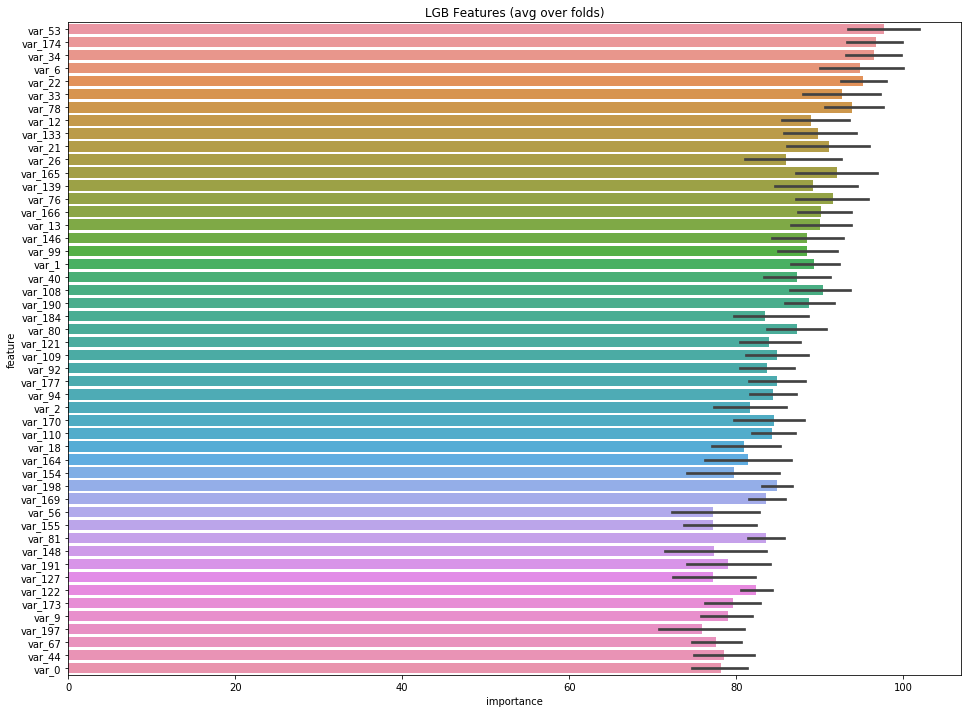

In [41]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Feb 26 22:59:42 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.88867	valid_1's auc: 0.865607
[2000]	training's auc: 0.913621	valid_1's auc: 0.883659
[3000]	training's auc: 0.925408	valid_1's auc: 0.890807
[4000]	training's auc: 0.932813	valid_1's auc: 0.894269
[5000]	training's auc: 0.938247	valid_1's auc: 0.895857
[6000]	training's auc: 0.943217	valid_1's auc: 0.896515
[7000]	training's auc: 0.948105	valid_1's auc: 0.896773
Early stopping, best iteration is:
[7173]	training's auc: 0.948961	valid_1's auc: 0.8968
Fold 1 started at Tue Feb 26 23:18:32 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.888489	valid_1's auc: 0.865396
[2000]	training's auc: 0.913382	valid_1's auc: 0.883756
[3000]	training's auc: 0.925389	valid_1's auc: 0.891102
[4000]	training's auc: 0.932576	valid_1's auc: 0.89485
[5000]	training's auc: 0.938038	valid_1's auc: 0.896699
[6000]	training's auc: 0.9429

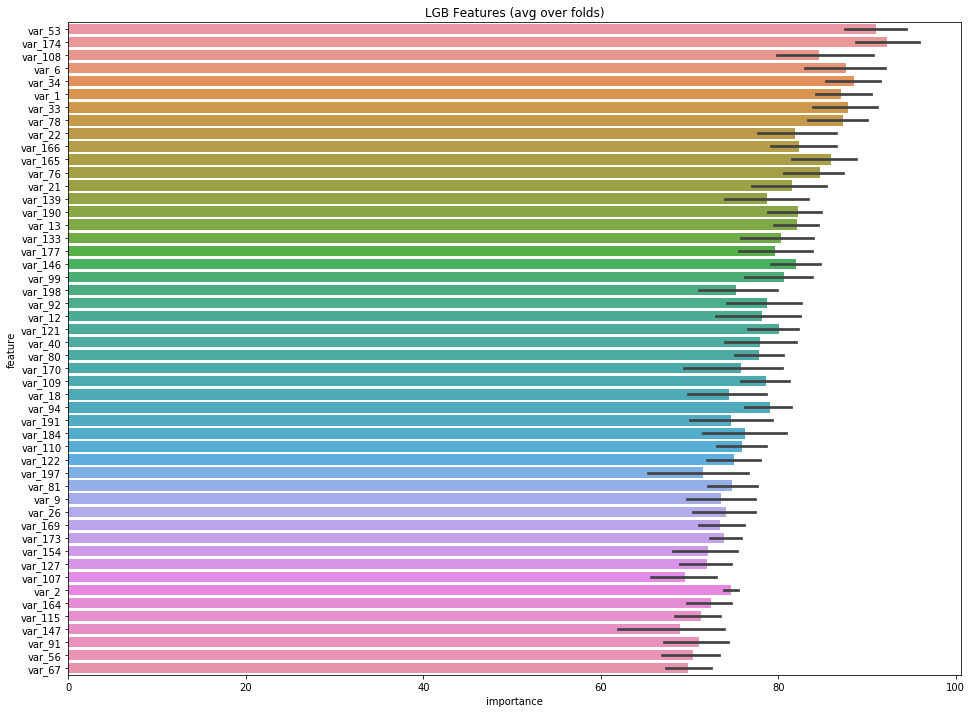

In [17]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'scale_pos_weight': sample_pos_weight,
         'num_threads': 4}
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [18]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Wed Feb 27 12:56:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.885014	valid_1's auc: 0.864492
[2000]	training's auc: 0.909721	valid_1's auc: 0.882867
[3000]	training's auc: 0.921202	valid_1's auc: 0.89042
[4000]	training's auc: 0.928088	valid_1's auc: 0.89445
[5000]	training's auc: 0.932895	valid_1's auc: 0.896647
[6000]	training's auc: 0.936977	valid_1's auc: 0.897681
[7000]	training's auc: 0.940894	valid_1's auc: 0.898105
[8000]	training's auc: 0.944607	valid_1's auc: 0.898296
Early stopping, best iteration is:
[8530]	training's auc: 0.946556	valid_1's auc: 0.898392
Fold 1 started at Wed Feb 27 13:10:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884713	valid_1's auc: 0.864687
[2000]	training's auc: 0.90936	valid_1's auc: 0.883356
[3000]	training's auc: 0.921266	valid_1's auc: 0.891113
[4000]	training's auc: 0.928168	valid_1's auc: 0.895326
[5000]	training's auc: 0.932

KeyboardInterrupt: 

In [19]:
np.save('../cache/oof_lgb', oof_lgb)
np.save('../cache/prediction_lgb', prediction_lgb)
np.save('../cache/scores', scores)

In [27]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub1a.csv', index=False)

In [ ]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f ../submissions/sub1a.csv -m " "

In [ ]:
!kaggle competitions submissions -c santander-customer-transaction-prediction

Fold 0 started at Tue Feb 19 13:21:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.866485	valid_1's auc: 0.84906
[2000]	training's auc: 0.895269	valid_1's auc: 0.872443
[3000]	training's auc: 0.908978	valid_1's auc: 0.882687
[4000]	training's auc: 0.91745	valid_1's auc: 0.888379
[5000]	training's auc: 0.92327	valid_1's auc: 0.892014
[6000]	training's auc: 0.927657	valid_1's auc: 0.894364
[7000]	training's auc: 0.93108	valid_1's auc: 0.896081
[8000]	training's auc: 0.933934	valid_1's auc: 0.897067
[9000]	training's auc: 0.936585	valid_1's auc: 0.897746
[10000]	training's auc: 0.939144	valid_1's auc: 0.898183
[11000]	training's auc: 0.941678	valid_1's auc: 0.898428
Early stopping, best iteration is:
[10897]	training's auc: 0.941448	valid_1's auc: 0.898463
Fold 1 started at Tue Feb 19 13:30:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.866744	valid_1's auc: 0.849655
[2000]	training's auc: 0.8

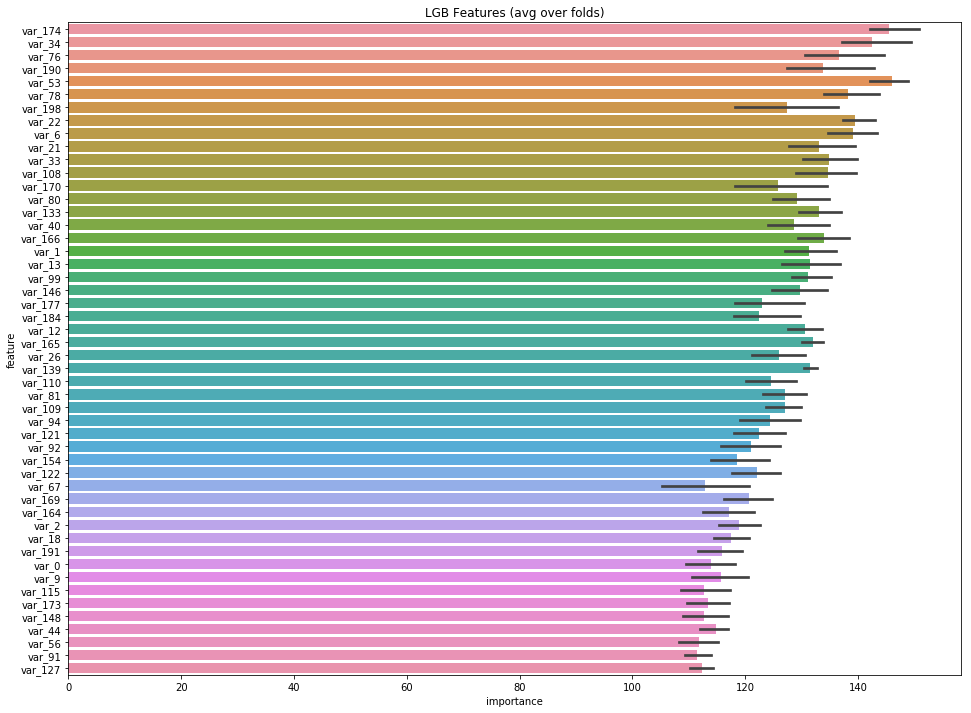

In [23]:
best = {'bagging_freq': 14, 'feature_fraction': 0.6645452259093495, 'learning_rate': 0.9104709179139949, 'max_depth': 18, 
        'min_child_weight': 0.1936027500260209, 'min_data_in_leaf': 6, 'min_gain_to_split': 0.3165755403433436, 
        'num_leaves': 1788, 'reg_alpha': 0.1962993164404836, 'metric': 'auc', 'boosting': 'gbdt',
         'verbosity': -1,
        'reg_lambda': 0.12729980022303397, 'subsample': 0.6191170180441716}
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.008,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb1, prediction_lgb1, scores1 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [24]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb1
sub.to_csv('../submissions/sub1b.csv', index=False)

In [21]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [42]:
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884796	valid_1's auc: 0.863996
[2000]	training's auc: 0.909754	valid_1's auc: 0.883341
[3000]	training's auc: 0.921236	valid_1's auc: 0.891485
[4000]	training's auc: 0.928121	valid_1's auc: 0.895495
[5000]	training's auc: 0.932972	valid_1's auc: 0.897463
[6000]	training's auc: 0.936911	valid_1's auc: 0.898596
[7000]	training's auc: 0.94072	valid_1's auc: 0.899005
Early stopping, best iteration is:
[7641]	training's auc: 0.943127	valid_1's auc: 0.899255


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [43]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0254,var_81
0.0215,var_139
0.0195,var_12
0.0176,var_110
0.0167,var_53
0.0158,var_6
0.0155,var_26
0.0153,var_174
0.0150,var_146
0.0148,var_22


In [44]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=120, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0254,var_81
0.0215,var_139
0.0195,var_12
0.0176,var_110
0.0167,var_53
0.0158,var_6
0.0155,var_26
0.0153,var_174
0.0150,var_146
0.0148,var_22


In [45]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = X[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883739	valid_1's auc: 0.863615
[2000]	training's auc: 0.904231	valid_1's auc: 0.881132
[3000]	training's auc: 0.912039	valid_1's auc: 0.887247
[4000]	training's auc: 0.916339	valid_1's auc: 0.889774
[5000]	training's auc: 0.919738	valid_1's auc: 0.890673
[6000]	training's auc: 0.923393	valid_1's auc: 0.890992
[7000]	training's auc: 0.927153	valid_1's auc: 0.89109
Early stopping, best iteration is:
[6822]	training's auc: 0.926471	valid_1's auc: 0.891122


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [46]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:110]
X1 = X[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884874	valid_1's auc: 0.863816
[2000]	training's auc: 0.905387	valid_1's auc: 0.878726
[3000]	training's auc: 0.913169	valid_1's auc: 0.883672
[4000]	training's auc: 0.917501	valid_1's auc: 0.885457
[5000]	training's auc: 0.920693	valid_1's auc: 0.886076
Early stopping, best iteration is:
[5468]	training's auc: 0.922375	valid_1's auc: 0.886293


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [51]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)


In [52]:
columns = top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:30]
for col1 in tqdm_notebook(columns):
    for col2 in columns:
        X[col1 + '_' + col2] = X[col1] * X[col2]   
        X_test[col1 + '_' + col2] = X_test[col1] * X_test[col2]
        
        X[col1 + '__' + col2] = X[col1] / X[col2]   
        X_test[col1 + '__' + col2] = X_test[col1] / X_test[col2]

In [53]:
oof_lgb2, prediction_lgb_inter, scores2 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)


Fold 0 started at Tue Feb 19 16:17:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884054	valid_1's auc: 0.861962
[2000]	training's auc: 0.909109	valid_1's auc: 0.880804
[3000]	training's auc: 0.9208	valid_1's auc: 0.888573
[4000]	training's auc: 0.928138	valid_1's auc: 0.892489
[5000]	training's auc: 0.933742	valid_1's auc: 0.894392
[6000]	training's auc: 0.939031	valid_1's auc: 0.895506
[7000]	training's auc: 0.944003	valid_1's auc: 0.896052
Early stopping, best iteration is:
[7332]	training's auc: 0.945604	valid_1's auc: 0.896094
Fold 1 started at Tue Feb 19 16:54:14 2019
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

In [17]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)


In [55]:
columns = top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:10]
for col1 in tqdm_notebook(columns):
    for col2 in columns:
        X[col1 + '_' + col2] = X[col1] * X[col2]   
        X_test[col1 + '_' + col2] = X_test[col1] * X_test[col2]
        
        X[col1 + '__' + col2] = X[col1] / X[col2]   
        X_test[col1 + '__' + col2] = X_test[col1] / X_test[col2]

Fold 0 started at Tue Feb 19 16:56:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883658	valid_1's auc: 0.86286
[2000]	training's auc: 0.909206	valid_1's auc: 0.882228
[3000]	training's auc: 0.920836	valid_1's auc: 0.890004
[4000]	training's auc: 0.927904	valid_1's auc: 0.893952
[5000]	training's auc: 0.932834	valid_1's auc: 0.896024
[6000]	training's auc: 0.937139	valid_1's auc: 0.897046
[7000]	training's auc: 0.941286	valid_1's auc: 0.897438
[8000]	training's auc: 0.945246	valid_1's auc: 0.897627
Early stopping, best iteration is:
[8320]	training's auc: 0.946518	valid_1's auc: 0.897761
Fold 1 started at Tue Feb 19 17:06:59 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883323	valid_1's auc: 0.863649
[2000]	training's auc: 0.908523	valid_1's auc: 0.882941
[3000]	training's auc: 0.920697	valid_1's auc: 0.890695
[4000]	training's auc: 0.927751	valid_1's auc: 0.894752
[5000]	training's auc: 0.9

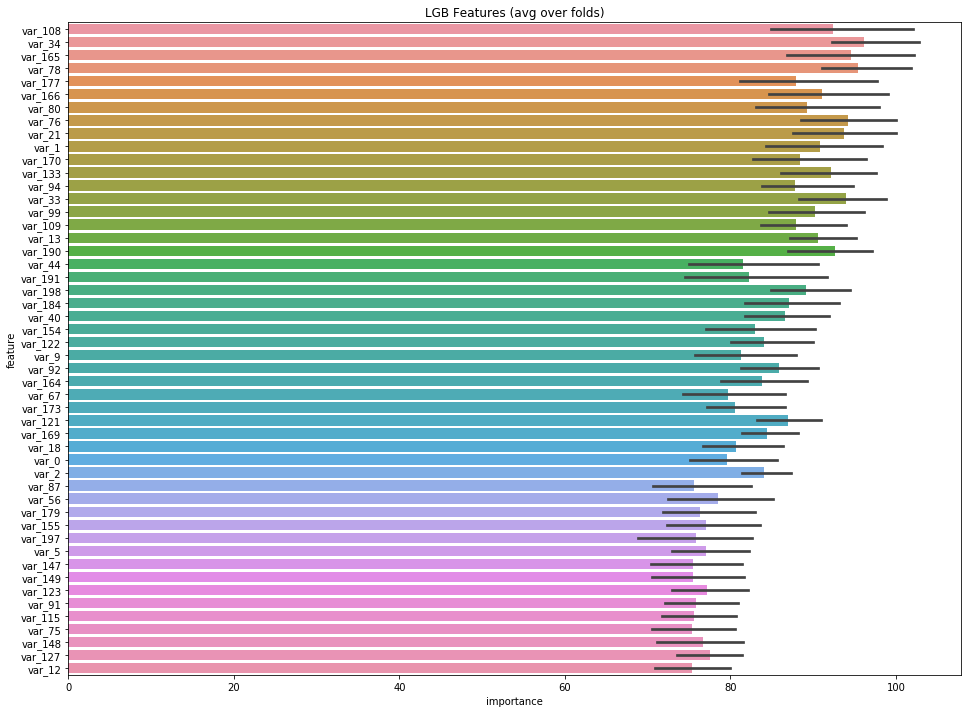

In [56]:
oof_lgb2, prediction_lgb_inter, scores2 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)


In [57]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb_inter
sub.to_csv('../submissions/sub1c.csv', index=False)

In [16]:

xgb_params = {'eta': 0.05, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb, scores = train_model(X, X_test, y, params=xgb_params, folds=folds, model_type='xgb')

Fold 0 started at Tue Feb 19 18:43:50 2019
[0]	train-auc:0.608758	valid_data-auc:0.601929
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.907889	valid_data-auc:0.872789
[1000]	train-auc:0.932237	valid_data-auc:0.887631
[1500]	train-auc:0.943743	valid_data-auc:0.893153
[2000]	train-auc:0.951329	valid_data-auc:0.894989
[2500]	train-auc:0.957301	valid_data-auc:0.895685
Stopping. Best iteration:
[2641]	train-auc:0.958613	valid_data-auc:0.895861

Fold 1 started at Tue Feb 19 19:09:56 2019
[0]	train-auc:0.599652	valid_data-auc:0.592425
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.907902	valid_data-auc:0.874244
[1000]	train-auc:0.932342	valid_data-auc:0.889326
[1500]	train-auc:0.943571	valid_data-auc:0.894195
[2000]	train-auc:0.951021	valid_data-

In [17]:
np.save('../cache/oof_xgb', oof_xgb)
np.save('../cache/prediction_xgb', prediction_xgb)
np.save('../cache/scores_xgb', scores)

In [18]:
cat_params = {'depth': 13,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat, _ = train_model(X, X_test, y, params=cat_params, folds=folds, model_type='cat')

Fold 0 started at Tue Feb 19 22:12:22 2019
Fold 1 started at Tue Feb 19 23:40:41 2019
Fold 2 started at Wed Feb 20 00:58:51 2019
Fold 3 started at Wed Feb 20 01:56:55 2019
Fold 4 started at Wed Feb 20 03:01:35 2019
CV mean score: 0.8853, std: 0.0029.


In [19]:
np.save('../cache/oof_cat', oof_cat)
np.save('../cache/prediction_cat', prediction_cat)
# np.save('../cache/scores_xgb', scores)

In [15]:
X = pd.DataFrame()
oof_lgb = np.load('../cache/oof_lgb.npy')
oof_xgb = np.load('../cache/oof_xgb.npy')
oof_cat = np.load('../cache/oof_cat.npy')
X['lgb'] = oof_lgb
X['xgb'] = oof_xgb
X['cat'] = oof_cat

In [16]:
X_test = pd.DataFrame()
prediction_lgb = np.load('../cache/prediction_lgb.npy')
prediction_xgb = np.load('../cache/prediction_xgb.npy')
prediction_cat = np.load('../cache/prediction_cat.npy')
X_test['lgb'] = prediction_lgb
X_test['xgb'] = prediction_xgb
X_test['cat'] = prediction_cat

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5000)
rf.fit(X,y)
preds = rf.predict(X_test)

In [19]:
preds = rf.predict_proba(X_test)[:,1]

In [20]:
preds

array([0.063 , 0.3526, 0.3106, ..., 0.    , 0.1332, 0.1004])

In [21]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds
sub.to_csv('../submissions/sub1d.csv', index=False)

In [22]:
preds1 = np.clip(preds, 0.05, 0.95)

In [23]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds1
sub.to_csv('../submissions/sub1e.csv', index=False) 

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X,y)
preds = rf.predict(X_test)

In [30]:
preds = rf.predict_proba(X_test)[:,1]


In [31]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds
sub.to_csv('../submissions/sub1g.csv', index=False) 

In [32]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = (prediction_lgb + prediction_xgb)/2
sub.to_csv('../submissions/sub1h.csv', index=False) 

In [33]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = (prediction_lgb + prediction_xgb + prediction_cat)/3
sub.to_csv('../submissions/sub1i.csv', index=False) 